In [1]:
# %load ../ionsrcopt/load_data.py
import pandas as pd
import numpy as np

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df


def set_BCT25_current_none(df, condition):
    df['ITF.BCT25:CURRENT'] = np.select([condition], [np.nan], [df['ITF.BCT25:CURRENT']])

def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    #df.dropna(inplace=True)
    if 'ITF.BCT15:CURRENT' in df.columns:
        #df.drop(df[df['ITF.BCT15:CURRENT'] < 0].index, inplace=True)
        set_BCT25_current_none(df, df['ITF.BCT15:CURRENT'] < 0)
    if 'ITF.BCT25:CURRENT' in df.columns:
        #df.drop(df[df['ITF.BCT25:CURRENT'] < 0].index, inplace=True)
        set_BCT25_current_none(df, df['ITF.BCT25:CURRENT'] < 0)
    if 'ITH.BCT41:CURRENT' in df.columns:
        #df.drop(df[df['ITH.BCT41:CURRENT'] < 0].index, inplace=True)
        set_BCT25_current_none(df, df['ITH.BCT41:CURRENT'] < 0)
    if 'ITL.BCT05:CURRENT' in df.columns:
        #df.drop(df[df['ITL.BCT05:CURRENT'] < 0].index, inplace=True)
        set_BCT25_current_none(df, df['ITL.BCT05:CURRENT'] < 0)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:OVEN1AQNP'] < 4.5].index, inplace=True)
        set_BCT25_current_none(df, df['IP.NSRCGEN:OVEN1AQNP'] < 4.5)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        #df.drop(df[df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200].index, inplace=True)
        set_BCT25_current_none(df, df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:BIASDISCAQNV'] == 0].index, inplace=True)
        set_BCT25_current_none(df, df['IP.NSRCGEN:BIASDISCAQNV'] == 0)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        #df.drop(df[df['IP.SAIREM2:FORWARDPOWER'] < 500].index, inplace=True)
        set_BCT25_current_none(df, df['IP.SAIREM2:FORWARDPOWER'] < 500)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5].index, inplace=True)
        set_BCT25_current_none(df, df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        #df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5].index, inplace=True)
        set_BCT25_current_none(df, df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5)
    
    return df

In [2]:
# %load ../ionsrcopt/annotation_tools.py
import os
import re

import dateutil.parser as parser

def export_for_annotation(filename, column_to_export, rows):
    """ Export a section of time series data in a format that can be used for annotation with the tool from https://trainset.geocene.com/

    Parameters:
        filename (string): The name of the files, from where to extract the data
        column_to_export (string): Column to be extracted
        rows (list of range): Ranges of the rows to be extracted, all are going to be saved in seperate files in Data_Annotated/
    """
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0]
    df = read_data_from_csv(filename, ['Timestamp (UTC_TIME)', column_to_export], None)
    df.insert(0, 'filename', 'f')
    df['label'] = 0
    df.columns = ['filename', 'timestamp', 'value', 'label']
    df.dropna(inplace=True)
    rows = [list(x) for x in rows]

    for x in rows:
        filename_output = filename_without_ext + "_" + str(x[0]).zfill(7) + "_" + str(x[-1]).zfill(7)
        print("Saving {}...".format(filename_output))

        sub_df = df.iloc[x].copy()
        sub_df['filename'] = filename_output
        sub_df['timestamp'] = sub_df['timestamp'].apply(lambda timestamp: parser.parse(timestamp).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] + "Z")
        sub_df.to_csv("Data_Annotated/" + filename_output + ".csv", index=False)

def get_annotated_files(dirname):
    """ List all .csv files in the folder 'Data_Annotated'

    Parameters:
        dirname (string): root directory of the files containing annotated data

    Returns:
        list of sting: A list of filenames
    """

    return [dirname + '/' + f for f in os.listdir(dirname + '/') if f.endswith('.csv')]

def import_annotated_data(filenames=[], dirname=''):
    """ Imports all the annotated data into dataframes

    Prameters: 
        filenames (list of string): The files to load. If empty, then everything from dirname will be imported
        dirname (string): Directory that should be loaded if no files are specified.

    Returns:
        list of DataFrame
    """

    if not filenames and not dirname:
        raise ValueError('At least one of the parameters has to be non empty')

    columns = ['timestamp', 'value', 'label']

    if not filenames:
        filenames = get_annotated_files(dirname)
    filenames.sort()

    annotated_dfs = []
    previous_groups = {}
    for f in filenames:
        groups = re.search(r"(.*)_([0-9]*)_([0-9]*).csv", f).groups()
        groups = { 'filename' : groups[0], 'start_index' : int(groups[1]) , 'end_index' : int(groups[2])  }
        df = read_data_from_csv(f, columns, None)
        df = convert_column(df, 'value', 'float32')
        df = convert_column(df, 'label', 'int32')
        df.index = range(groups['start_index'], groups['end_index']+1)

        if previous_groups and previous_groups['filename'] == groups ['filename'] and previous_groups['end_index'] == (groups['start_index']-1):
            annotated_dfs[-1] =  annotated_dfs[-1].append(df)
        else:
            annotated_dfs.append(df)

        previous_groups = groups
    
    return annotated_dfs

In [18]:
# %load ../ionsrcopt/source_stability.py
import pandas as pd
import numpy as np

def stability_mean_variance_classification(df, current_column, sliding_window_size=5000, minimum_mean=0.025, maximum_variance=0.00005):
    """ Classifies all point in the data frame into the categories source stable/unstable, based on a rolling window and a minimum mean and maximum variance in this window.

    Parameters:
        df (DataFrame): The data input loaded as a DataFrame
        current_column (string): name of the column that contains the beam current we are interested in, typically BCT25
        sliding_window_size (int): size of the sliding window, by default 5000 (100 Minutes of data every 1.2 seconds)
        minimum_mean (double): minimal intensity of the beam in the sliding window for it to be considered stable
        maximum_variance (double): maximum variance of intensity of the beam in the sliding window for it to be considered stable

    Returns:
        Series: A series that for every data point indicates if the source was running stable or not (1 is stable, 0 is unstable)
    """

    rolling = df[current_column].rolling(sliding_window_size, center=True)
    mean = np.array(rolling.mean())
    var = np.array(rolling.var())

    result = [int(m > minimum_mean and v < maximum_variance) if not np.isnan(m) and not np.isnan(v) else np.nan for (m, v) in zip(mean, var)]
    
    return pd.Series(result, index=df.index)

In [4]:
annotated_data = import_annotated_data(dirname='../Data_Annotated')

Loading data from csv file '../Data_Annotated/Nov2018_0000000_0029999.csv'
Converting column 'value' to 'float32'
Converting column 'label' to 'int32'
Loading data from csv file '../Data_Annotated/Nov2018_0030000_0059999.csv'
Converting column 'value' to 'float32'
Converting column 'label' to 'int32'
Loading data from csv file '../Data_Annotated/Nov2018_0060000_0089999.csv'
Converting column 'value' to 'float32'
Converting column 'label' to 'int32'
Loading data from csv file '../Data_Annotated/Nov2018_0090000_0119999.csv'
Converting column 'value' to 'float32'
Converting column 'label' to 'int32'
Loading data from csv file '../Data_Annotated/Nov2018_0120000_0149999.csv'
Converting column 'value' to 'float32'
Converting column 'label' to 'int32'
Loading data from csv file '../Data_Annotated/Nov2018_0500000_0529999.csv'
Converting column 'value' to 'float32'
Converting column 'label' to 'int32'
Loading data from csv file '../Data_Annotated/Nov2018_0530000_0559999.csv'
Converting column '

In [13]:
def compare_to_label(df, column_to_compare):
    print('started comparing {}'.format(column_to_compare))
    
    falsely_marked_as_stable_count = 0
    falsely_marked_as_unstable_count = 0
    
    for _, row in df.iterrows():
        if row['label'] == 1 and row[column_to_compare] == 0:
            falsely_marked_as_unstable_count += 1
        elif row['label'] == 0 and row[column_to_compare] == 1:
            falsely_marked_as_stable_count += 1
    
    return { 'falsely_marked_as_stable_count' : falsely_marked_as_stable_count, 'falsely_marked_as_unstable_count' : falsely_marked_as_unstable_count }

### Accuracy of max-mean-min-variance method
Below we will try out the accuracy of this method in camparison to data labeled by hand.

started comparing stability_mean_variance_classification


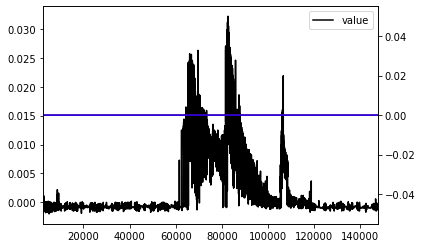

started comparing stability_mean_variance_classification


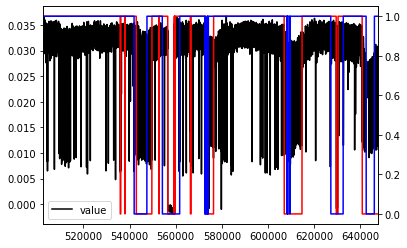

started comparing stability_mean_variance_classification


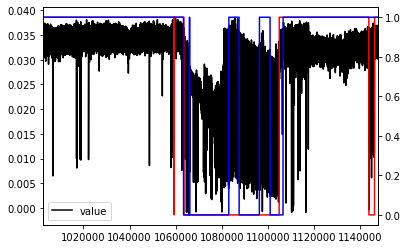

started comparing stability_mean_variance_classification


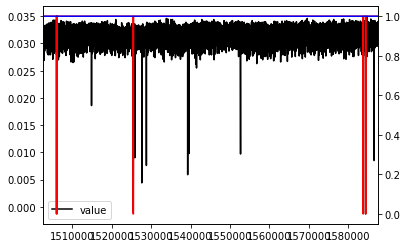

started comparing stability_mean_variance_classification


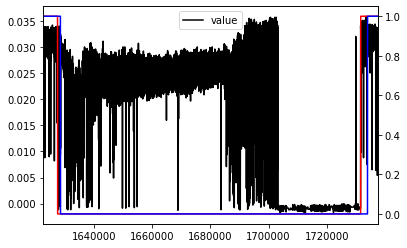

From a total of 635005 data points, 28683 (4.5%) were incorrectly marked as 'stable', while 15040 (2.4%) were incorrectly marked as 'unstable', resulting in a total error of 6.9%.


In [21]:
import matplotlib
import matplotlib.pyplot as plt

total_count = 0
falsely_marked_as_stable_count = 0
falsely_marked_as_unstable_count = 0

for df in annotated_data:
    df['stability_mean_variance_classification'] = stability_mean_variance_classification(df, 'value', sliding_window_size=5000, minimum_mean=0.027, maximum_variance=0.000035)
    df = df.dropna()
    comparison = compare_to_label(df, 'stability_mean_variance_classification')
    
    falsely_marked_as_stable_count += comparison['falsely_marked_as_stable_count']
    falsely_marked_as_unstable_count += comparison['falsely_marked_as_unstable_count']
    total_count += len(df.index)
    
    df.plot(y=['value'], color='black')
    df['label'].plot(secondary_y=True, color='red')
    df['stability_mean_variance_classification'].plot(secondary_y=True, color='blue')
    plt.show()
    
print("From a total of {0} data points, {1} ({2:.1f}%) were incorrectly marked as 'stable', while {3} ({4:.1f}%) were incorrectly marked as 'unstable', resulting in a total error of {5:.1f}%.".format(
    total_count, 
    falsely_marked_as_stable_count, falsely_marked_as_stable_count / total_count * 100, 
    falsely_marked_as_unstable_count, falsely_marked_as_unstable_count / total_count * 100, (falsely_marked_as_stable_count + falsely_marked_as_unstable_count) / total_count * 100))

With the given parameters an accuracy of 6-8% is achieved. Nevertheless, this sould be cross validated with some unknown and new data, because the parameters were chosen on basis of experiments of the _Nov2018_ data.